### Charger et compiler le projet density
___

In [1]:
# Verifier qu'on se trouve dans le répertoire PhysiCell
!ls

NN	   dev_files   requirements.txt		  sbi_project_ecm_rules.ipynb
PhysiCell  env	       sbi_project_density.ipynb  sbi_toolbox.ipynb
README.md  output.png  sbi_project_ecm.ipynb


In [2]:
# Sinon, se déplacer dans le répertoire PhysiCell
import os
os.chdir("PhysiCell")

In [3]:
# Ici, changer et mettre le bon nom du projet
project_name = "density"

In [4]:
!make clean
!make data-cleanup
!make reset
!make load PROJ=$project_name
!make

rm -f *.o
rm -f project*
rm -rf ./output
mkdir ./output
touch ./output/empty.txt
rm -f *.cpp 
cp ./sample_projects/Makefile-default Makefile 
rm -f ./custom_modules/*
touch ./custom_modules/empty.txt 
touch ALL_CITATIONS.txt 
touch ./core/PhysiCell_cell.cpp
rm ALL_CITATIONS.txt 
cp ./config/PhysiCell_settings-backup.xml ./config/PhysiCell_settings.xml 
touch ./config/empty.csv
rm -f ./config/*.csv
echo "Loading project from density ... "
Loading project from density ... 
cp ./user_projects/density/main.cpp .
cp ./user_projects/density/Makefile .
cp ./user_projects/density/config/* ./config/ 
cp ./user_projects/density/custom_modules/* ./custom_modules/ 
g++ -march=native  -O3 -fomit-frame-pointer -mfpmath=both -fopenmp -m64 -std=c++11  -c ./BioFVM/BioFVM_vector.cpp 
g++ -march=native  -O3 -fomit-frame-pointer -mfpmath=both -fopenmp -m64 -std=c++11  -c ./BioFVM/BioFVM_mesh.cpp 
g++ -march=native  -O3 -fomit-frame-pointer -mfpmath=both -fopenmp -m64 -std=c++11  -c ./BioFVM/BioFVM_microen

### Modifier le projet
___

In [5]:
# Si on souhaite ouvrir l'interface du projet

!python3 studio/bin/studio.py -e project -c config/PhysiCell_settings.xml

args= Namespace(bare=False, three=False, tensor=False, skip_validate=False, nanohub=False, config='config/PhysiCell_settings.xml', exec='project')
unknown= []
exec_file exists
PhysiCellXMLCreator(): self.nanohub_flag=  False
  platform.system().lower()=linux, platform.machine()=x86_64
Could not parse application stylesheet
self.current_dir =  /home/aymeric/tumor-simulation/PhysiCell
self.studio_root_dir =  /home/aymeric/tumor-simulation/PhysiCell/studio
self.config_dir =  /home/aymeric/tumor-simulation/PhysiCell/config
got config_file= config/PhysiCell_settings.xml
studio: (default) self.config_file = /home/aymeric/tumor-simulation/PhysiCell/config/PhysiCell_settings.xml
studio: (default) self.tree = <xml.etree.ElementTree.ElementTree object at 0x7f393ee9ebf0>
studio: (default) self.xml_root = <Element 'PhysiCell_settings' at 0x7f393eea09f0>
QLayout::addChildLayout: layout "" already has a parent
Could not parse stylesheet of object Config(0x562596421850)
studio.py: ---- FALSE nanohub_

In [6]:
# Sauvegarder les modifications réalisées dans user_projects
!make save PROJ=$project_name

echo "Saving project as density ... "
Saving project as density ... 
mkdir -p ./user_projects
mkdir -p ./user_projects/density
mkdir -p ./user_projects/density/custom_modules
mkdir -p ./user_projects/density/config 
cp main.cpp ./user_projects/density
cp Makefile ./user_projects/density
cp VERSION.txt ./user_projects/density
cp ./config/* ./user_projects/density/config
cp ./custom_modules/* ./user_projects/density/custom_modules


## SBI
___

In [7]:
import xml.etree.ElementTree as ET

def modify_xml_value(file_path, tag_path, new_value):
    tree = ET.parse(file_path)
    root = tree.getroot()
    element = root
    for tag in tag_path:
        element = element.find(tag)
        if element is None:
            print(f"Balise '{tag}' non trouvée dans le chemin spécifié.")
            return False
    element.text = str(new_value)
    tree.write(file_path, encoding="utf-8", xml_declaration=True)
    return True

In [8]:
import csv
def change_csv_value(csv_file_path, row_index, column_index, new_value):
    # Read the CSV file into a list of lists
    with open(csv_file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        data = list(reader)
    # Update the value of the specified cell
    if 0 <= row_index < len(data) and 0 <= column_index < len(data[row_index]):
        data[row_index][column_index] = str(new_value)

        # Save the modified data to the CSV file
        with open(csv_file_path, 'w', newline='') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerows(data)

    else:
        print(f"Invalid row index ({row_index}) or column index ({column_index})")


In [12]:
import numpy as np
import scipy.io
def calculate_distances(points, center):
    distances = np.sqrt((points[:, 0] - center[0])**2 + (points[:, 1] - center[1])**2)
    return distances

def radial_density(distances, step=10, max_distance=500):
    # Créer les bins avec une taille allant jusqu'à 500 et un step de 10
    bins = np.arange(0, max_distance + step, step)
    counts, _ = np.histogram(distances, bins)
    areas = np.pi * (bins[1:]**2 - bins[:-1]**2)
    densities = counts / areas
    return bins[:-1], densities

def get_radial_density(path_mat):
    mat = scipy.io.loadmat(path_mat)
    X = mat['cells'][1]
    Y = mat['cells'][2]
    points = np.column_stack((X, Y));
    center = np.array([0,0]);
    distances = calculate_distances(points, center)
    radii, densities = radial_density(distances)
    resultat = [elem for pair in zip(radii, densities) for elem in pair]
    return resultat


In [13]:
import torch
import subprocess

def simulation(params):

    if len(params.shape) == 1:
        n = 1
        num_params = len(params)
    else:
        n, num_params = params.shape
    
    results = []
    
    for i in range(n):
        if n == 1:
            current_params = params
        else:
            current_params = params[i]

        # Liste des chemins XML et des noms de paramètres
        xml_paths = [
            ["cell_definitions", "cell_definition[@name='cancer']", "phenotype", "motility", "speed"]
        ]

       
        for j in range(min(num_params, len(xml_paths))):
            modify_xml_value("config/PhysiCell_settings.xml", xml_paths[j], current_params[j].item())
        

        subprocess.run(["./project"], stdout=subprocess.DEVNULL)

        
        radial_density = get_radial_density('/home/aymeric/tumor-simulation/PhysiCell/output/final_cells.mat')
        results.append(torch.tensor(radial_density))

    results = torch.cat(results)
    return results.flatten()

In [14]:
print(simulation(torch.tensor([0.2])))

tensor([0.0000e+00, 0.0000e+00, 1.0000e+01, 0.0000e+00, 2.0000e+01, 6.3662e-04,
        3.0000e+01, 1.3642e-03, 4.0000e+01, 1.4147e-03, 5.0000e+01, 1.1575e-03,
        6.0000e+01, 9.7942e-04, 7.0000e+01, 1.4854e-03, 8.0000e+01, 1.3107e-03,
        9.0000e+01, 1.5078e-03, 1.0000e+02, 1.5158e-03, 1.1000e+02, 1.9375e-03,
        1.2000e+02, 1.9099e-03, 1.3000e+02, 2.8294e-03, 1.4000e+02, 2.1952e-03,
        1.5000e+02, 3.0804e-03, 1.6000e+02, 4.3406e-03, 1.7000e+02, 4.4563e-03,
        1.8000e+02, 6.0221e-03, 1.9000e+02, 5.0603e-03, 2.0000e+02, 6.5215e-03,
        2.1000e+02, 6.9584e-03, 2.2000e+02, 6.5077e-03, 2.3000e+02, 1.4222e-03,
        2.4000e+02, 0.0000e+00, 2.5000e+02, 0.0000e+00, 2.6000e+02, 0.0000e+00,
        2.7000e+02, 0.0000e+00, 2.8000e+02, 0.0000e+00, 2.9000e+02, 0.0000e+00,
        3.0000e+02, 0.0000e+00, 3.1000e+02, 0.0000e+00, 3.2000e+02, 0.0000e+00,
        3.3000e+02, 0.0000e+00, 3.4000e+02, 0.0000e+00, 3.5000e+02, 0.0000e+00,
        3.6000e+02, 0.0000e+00, 3.7000e+

In [15]:
import torch
from sbi.inference import prepare_for_sbi

from sbi import utils as utils
from sbi import analysis as analysis


# Définir les bornes inférieures pour chaque dimension
low = torch.tensor([0])

# Définir les bornes supérieures pour chaque dimension
high = torch.tensor([2])

# Créer le a priori uniforme avec les bornes spécifiées
prior = utils.BoxUniform(low=low, high=high)

simulator, prior = prepare_for_sbi(simulation, prior)

/home/aymeric/tumor-simulation/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from sbi.inference import SNPE

inference = SNPE(prior=prior)

In [17]:
from sbi.inference import simulate_for_sbi

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=15) # 15 simulations pour l'exemple

Running 15 simulations.:   0%|          | 0/15 [00:00<?, ?it/s]

Running 15 simulations.: 100%|██████████| 15/15 [04:38<00:00, 18.57s/it]


In [18]:
# On ajoute les simulations à l'objet inference
inference = inference.append_simulations(theta, x)

# On entraîne le réseau de neurones
density_estimator = inference.train()


/home/aymeric/tumor-simulation/env/lib/python3.10/site-packages/sbi/neural_nets/flow.py:142: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 79 epochs.

In [19]:
posterior = inference.build_posterior(density_estimator)

In [20]:
theta = torch.tensor([0.2]) # Paramètre de départ que l'on cherche à prédire
x_o = simulation(theta) # Résultat de la simulation pour le paramètre de départ

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 91158.92it/s]


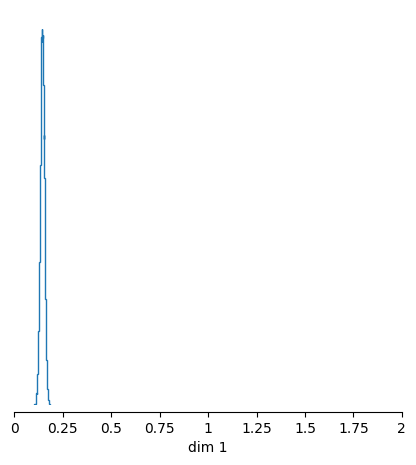

In [21]:
# On génère 10000 échantillons à partir du posterior (très rapide car on utilise un NN)
posterior_samples = posterior.sample((10000,), x=x_o) 

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[0, 2]], figsize=(5, 5) # bornes min et max pour chaque paramètre à changer
)